In [1]:
import pandas as pd
import os
import numpy as np
#np.set_printoptions(precision=4)
import catboost
from catboost import *

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FileNames =[
    'urine_chm100-120.csv',
    'urine_chm100-131s.csv',
    'urine_chm120-131.csv',
    'urine_chm132-144.csv',
    'urine_chm140-152.csv',
    'urine_chm153-152.csv',
    'urine_chm153-161.csv'
]

dataset_dir = './urine_chms'
Dataframes = []
for csv_name in FileNames:
    print(csv_name)
    if csv_name.startswith('urine'):
        Dataframes.append(pd.read_csv(os.path.join(dataset_dir, csv_name)))
    else : continue
Data_Spectra = pd.concat(Dataframes, axis=0)
Data_Spectra = Data_Spectra[Data_Spectra.Dataset != 'Flood']

urine_chm100-120.csv
urine_chm100-131s.csv
urine_chm120-131.csv
urine_chm132-144.csv
urine_chm140-152.csv
urine_chm153-152.csv
urine_chm153-161.csv


## Выделим образцы отдельно для стандартных банок и нестандартных

In [3]:
Standart_Chms_indicies = list(map( lambda x: x.endswith('s') ,Data_Spectra.Dataset.drop_duplicates().values))
Standart_Chms = Data_Spectra.Dataset.drop_duplicates().values[Standart_Chms_indicies]

NonStandart_Chms_indicies = list(map( lambda x: x.endswith('n') ,Data_Spectra.Dataset.drop_duplicates().values))
NonStandart_Chms = Data_Spectra.Dataset.drop_duplicates().values[NonStandart_Chms_indicies]

In [4]:
print(*sorted(Standart_Chms, key=lambda x: int(x[3:-1])))

Chm100s Chm103s Chm104s Chm105s Chm106s Chm108s Chm112s Chm113s Chm114s Chm116s Chm119s Chm120s Chm121s Chm123s Chm124s Chm125s Chm126s Chm128s Chm129s Chm130s Chm131s Chm132s Chm133s Chm134s Chm135s Chm136s Chm137s Chm138s Chm139s Chm140s Chm141s Chm142s Chm143s Chm144s Chm145s Chm146s Chm147s Chm148s Chm149s Chm150s Chm151s Chm152s Chm153s Chm154s Chm155s Chm156s Chm157s Chm158s Chm159s Chm160s Chm161s


In [5]:
print(*sorted(NonStandart_Chms, key=lambda x: int(x[3:-1])))

Chm105n Chm106n Chm107n Chm109n Chm110n Chm111n Chm112n Chm113n Chm114n Chm116n Chm119n Chm120n Chm121n Chm123n Chm125n Chm126n Chm128n Chm129n Chm130n Chm131n Chm132n Chm133n Chm134n Chm135n Chm136n Chm137n Chm138n Chm139n Chm140n Chm141n Chm143n Chm144n Chm145n Chm146n Chm147n Chm148n Chm149n Chm150n Chm151n Chm152n Chm153n Chm154n Chm155n Chm157n Chm158n Chm159n Chm160n Chm161n


In [8]:
Matching_data = pd.read_excel('19.09.23 список образцов Моча.xlsx', header=2)

In [9]:
Matching_data

,Порядковый номер,Значение BAR-CODE,номера спектров,ФИО,Unnamed: 4,Пол,Возраст,Цвет,Плотность,Плотность.1,...,Дрожжи.1,Малые клетки,Малые клетки.1,Цилиндры патологические,Цилиндры патологические.1,Слизь,Слизь.1,Сперматозоиды,Сперматозоиды.1,TOTAL
0,Chm1,10178199,NaN,NaN,NaN,m,24.0,COLORLESS,1.006,1.0,...,0.0,0.2,0.0,1.29,1.0,0.0,0.0,0.0,0.0,8
1,Chm2,10152917,NaN,NaN,NaN,f,62.0,YELLOW,1.028,0.0,...,0.0,6.3,1.0,3.11,1.0,42.0,1.0,0.0,0.0,12
2,Chm3,10152925,NaN,NaN,NaN,f,71.0,YELLOW,1.009,1.0,...,0.0,2.9,0.0,0.12,0.0,0.4,0.0,0.0,0.0,3
3,Chm4,10162383,NaN,NaN,NaN,f,57.0,YELLOW,1.018,0.0,...,0.0,2.7,0.0,0.64,0.0,0.1,0.0,0.0,0.0,4
4,Chm5,10163935,NaN,NaN,NaN,m,77.0,LIGHT YELLOW,1.029,1.0,...,0.0,1.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Chm157,20287185,NaN,NaN,NaN,f,18.0,LIGHT YELLOW,1.009,1.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,1
147,Chm158,20287183,NaN,NaN,NaN,m,21.0,YELLOW,1.019,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0
148,Chm159,20287181,NaN,NaN,NaN,m,19.0,YELLOW,1.034,1.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,3
149,Chm160,20287180,NaN,NaN,NaN,f,18.0,LIGHT YELLOW,1.006,1.0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,1


In [10]:
list(map(lambda x: x[:-1], NonStandart_Chms))

['Chm105',
 'Chm106',
 'Chm107',
 'Chm109',
 'Chm110',
 'Chm111',
 'Chm112',
 'Chm113',
 'Chm116',
 'Chm119',
 'Chm120',
 'Chm114',
 'Chm121',
 'Chm123',
 'Chm125',
 'Chm126',
 'Chm128',
 'Chm129',
 'Chm130',
 'Chm131',
 'Chm132',
 'Chm133',
 'Chm134',
 'Chm135',
 'Chm136',
 'Chm137',
 'Chm138',
 'Chm139',
 'Chm140',
 'Chm141',
 'Chm143',
 'Chm144',
 'Chm145',
 'Chm146',
 'Chm147',
 'Chm148',
 'Chm149',
 'Chm150',
 'Chm151',
 'Chm152',
 'Chm153',
 'Chm154',
 'Chm155',
 'Chm157',
 'Chm158',
 'Chm159',
 'Chm160',
 'Chm161']

In [11]:
Data_Spectra

,Id,CreationStamp,Dataset,Description,Ch_0_0,Ch_0_1,Ch_0_2,Ch_0_3,Ch_0_4,Ch_0_5,...,Ch_1_8,Ch_1_9,Ch_1_10,Ch_1_11,Ch_1_12,Ch_1_13,Ch_1_14,Ch_1_15,Ch_1_16,Ch_1_17
0,987,2019-10-23 08:41:16Z,Chm100,Spectrum1,136.2094,70.48598,358.8396,747.9769,819.7412,842.4570,...,247.0447,891.6899,971.3057,958.2036,624.6426,839.5734,145.8697,296.2978,151.8152,174.1982
1,988,2019-10-23 08:41:29Z,Chm100,Spectrum2,136.2094,72.39101,356.9460,740.4025,801.9637,834.5558,...,242.8857,915.8122,981.7875,951.2158,626.8815,901.1422,147.8233,276.7617,153.7615,192.6885
2,989,2019-10-23 08:41:34Z,Chm100,Spectrum3,131.4468,72.39101,348.4247,763.1259,796.0378,830.6053,...,246.2129,912.4850,975.6731,952.0892,608.9706,840.6929,149.1257,308.0195,152.7883,180.0372
3,990,2019-10-23 08:42:23Z,Chm100,Spectrum4,128.5893,67.62844,349.3715,724.3068,783.1985,786.1614,...,247.0447,942.4298,954.7097,992.2692,604.4929,880.9924,148.4745,273.5056,154.7347,189.7690
4,991,2019-10-23 08:42:30Z,Chm100,Spectrum5,128.5893,67.62844,339.9034,747.0302,778.2603,837.5187,...,247.0447,934.1118,952.9627,946.8484,602.2540,940.3223,150.4281,291.7393,155.7079,170.3055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2019,2019-10-25 09:27:39Z,Chm161s,Spectrum6,103.8239,60.96085,342.7439,1024.4440,886.9008,2395.0270,...,270.3351,707.8621,801.8513,739.8345,457.8474,670.5393,115.2631,218.8045,104.1296,128.4590
76,2020,2019-10-25 09:27:49Z,Chm161s,Spectrum7,105.7290,60.96085,355.9991,1043.3800,922.4558,2405.8910,...,267.0079,738.6387,787.8757,792.2431,447.7725,634.7175,115.2631,210.3389,103.1565,146.9493
77,2021,2019-10-25 09:27:59Z,Chm161s,Spectrum8,105.7290,63.81839,355.0523,1076.5190,920.4805,2434.5330,...,255.3627,768.5835,734.5936,835.9169,420.9062,659.3450,115.2631,218.8045,102.1833,150.8420
78,2022,2019-10-25 09:28:09Z,Chm161s,Spectrum9,107.6340,60.96085,360.7332,1019.7100,931.3445,2409.8420,...,252.8673,765.2563,721.4915,813.2065,406.3535,623.5232,114.6119,244.2015,102.1833,143.0566


In [12]:
NonStandart_Chms

array(['Chm105n', 'Chm106n', 'Chm107n', 'Chm109n', 'Chm110n', 'Chm111n',
       'Chm112n', 'Chm113n', 'Chm116n', 'Chm119n', 'Chm120n', 'Chm114n',
       'Chm121n', 'Chm123n', 'Chm125n', 'Chm126n', 'Chm128n', 'Chm129n',
       'Chm130n', 'Chm131n', 'Chm132n', 'Chm133n', 'Chm134n', 'Chm135n',
       'Chm136n', 'Chm137n', 'Chm138n', 'Chm139n', 'Chm140n', 'Chm141n',
       'Chm143n', 'Chm144n', 'Chm145n', 'Chm146n', 'Chm147n', 'Chm148n',
       'Chm149n', 'Chm150n', 'Chm151n', 'Chm152n', 'Chm153n', 'Chm154n',
       'Chm155n', 'Chm157n', 'Chm158n', 'Chm159n', 'Chm160n', 'Chm161n'],
      dtype=object)

In [13]:
Standart_Chms

array(['Chm104s', 'Chm108s', 'Chm100s', 'Chm103s', 'Chm105s', 'Chm106s',
       'Chm113s', 'Chm112s', 'Chm114s', 'Chm116s', 'Chm119s', 'Chm120s',
       'Chm121s', 'Chm123s', 'Chm125s', 'Chm126s', 'Chm128s', 'Chm129s',
       'Chm130s', 'Chm131s', 'Chm124s', 'Chm132s', 'Chm133s', 'Chm134s',
       'Chm135s', 'Chm136s', 'Chm137s', 'Chm138s', 'Chm139s', 'Chm142s',
       'Chm140s', 'Chm141s', 'Chm143s', 'Chm144s', 'Chm145s', 'Chm146s',
       'Chm147s', 'Chm148s', 'Chm149s', 'Chm150s', 'Chm151s', 'Chm156s',
       'Chm152s', 'Chm153s', 'Chm154s', 'Chm155s', 'Chm157s', 'Chm158s',
       'Chm159s', 'Chm160s', 'Chm161s'], dtype=object)

### Выделим пары общих номеров Chms для Стандартных и Нестандартных банок
Пересечение множеств номеров Chms для Standart и NonStandart

In [14]:
ChmsIntersection_of_Stand_and_NonSt = set.intersection( set(map(lambda x: x[:-1], Standart_Chms)), set(map(lambda x: x[:-1], NonStandart_Chms)) )

In [15]:
Standart_Data_Spectra = Data_Spectra[list(map(lambda x: (x[:-1] in ChmsIntersection_of_Stand_and_NonSt) and (x.endswith('s')), Data_Spectra.Dataset))]
Standart_Data_Spectra.drop(['Id', 'CreationStamp'], axis=1, inplace=True)
Standart_Data_Spectra['Dataset'] = Standart_Data_Spectra.Dataset.apply(lambda x: x[:-1]).values


/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
NonStandart_Data_Spectra = Data_Spectra[list(map(lambda x: (x[:-1] in ChmsIntersection_of_Stand_and_NonSt) and (x.endswith('n')), Data_Spectra.Dataset))]
NonStandart_Data_Spectra.drop(['Id', 'CreationStamp'], axis=1, inplace=True)
NonStandart_Data_Spectra['Dataset'] = NonStandart_Data_Spectra.Dataset.apply(lambda x: x[:-1]).values


/opt/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


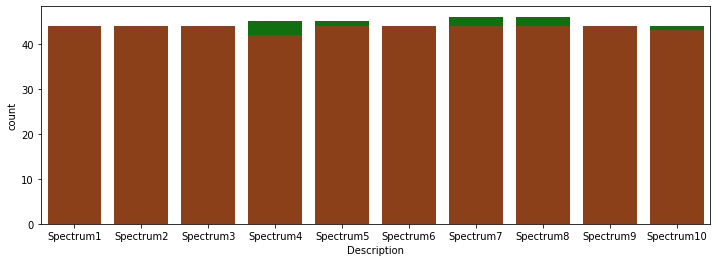

In [17]:
plt.figure(figsize=(12,4))
sns.countplot(Standart_Data_Spectra.Description, color='green', alpha=1)
sns.countplot(NonStandart_Data_Spectra.Description, color='red', alpha=0.6)

In [18]:
Matching_data[['Порядковый номер', 'Пол', 'Возраст', 'TOTAL']]

,Порядковый номер,Пол,Возраст,TOTAL
0,Chm1,m,24.0,8
1,Chm2,f,62.0,12
2,Chm3,f,71.0,3
3,Chm4,f,57.0,4
4,Chm5,m,77.0,1
...,...,...,...,...
146,Chm157,f,18.0,1
147,Chm158,m,21.0,0
148,Chm159,m,19.0,3
149,Chm160,f,18.0,1


In [17]:
Standart_Dataset = pd.merge(Standart_Data_Spectra, Matching_data[['Порядковый номер', 'Пол', 'Возраст', 'TOTAL']],
                            left_on='Dataset', right_on='Порядковый номер', how='left')
Standart_Dataset.drop('Порядковый номер', axis=1, inplace=True)


NonStandart_Dataset = pd.merge(NonStandart_Data_Spectra, Matching_data[['Порядковый номер', 'Пол', 'Возраст', 'TOTAL']],
                            left_on='Dataset', right_on='Порядковый номер', how='left')
NonStandart_Dataset.drop('Порядковый номер', axis=1, inplace=True)

In [18]:
## Добавим целевую бинарную метку TOTAL_bin : нет аномалий -- 0, если есть хотя бы одна -- 1
Standart_Dataset['TOTAL_bin'] = Standart_Dataset.TOTAL.apply(lambda x: 0 if x==0 else 1)
NonStandart_Dataset['TOTAL_bin'] = NonStandart_Dataset.TOTAL.apply(lambda x: 0 if x==0 else 1)

In [19]:
Standart_Dataset.dropna(inplace=True)
NonStandart_Dataset.dropna(inplace=True)

In [20]:
Standart_X = Standart_Dataset.iloc[:,2:-2]
NonStandart_X = NonStandart_Dataset.iloc[:,2:-2]

Standart_y = Standart_Dataset.TOTAL_bin
NonStandart_y = NonStandart_Dataset.TOTAL_bin

### Проверим датасеты на наличие пропусков и заполним их в случае наличия

In [21]:
Standart_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 445
Data columns (total 38 columns):
Ch_0_0     425 non-null float64
Ch_0_1     425 non-null float64
Ch_0_2     425 non-null float64
Ch_0_3     425 non-null float64
Ch_0_4     425 non-null float64
Ch_0_5     425 non-null float64
Ch_0_6     425 non-null float64
Ch_0_7     425 non-null float64
Ch_0_8     425 non-null float64
Ch_0_9     425 non-null float64
Ch_0_10    425 non-null float64
Ch_0_11    425 non-null float64
Ch_0_12    425 non-null float64
Ch_0_13    425 non-null float64
Ch_0_14    425 non-null float64
Ch_0_15    425 non-null float64
Ch_0_16    425 non-null float64
Ch_0_17    425 non-null float64
Ch_1_0     425 non-null float64
Ch_1_1     425 non-null float64
Ch_1_2     425 non-null float64
Ch_1_3     425 non-null float64
Ch_1_4     425 non-null float64
Ch_1_5     425 non-null float64
Ch_1_6     425 non-null float64
Ch_1_7     425 non-null float64
Ch_1_8     425 non-null float64
Ch_1_9     425 non-null float64

In [22]:
NonStandart_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 436
Data columns (total 38 columns):
Ch_0_0     417 non-null float64
Ch_0_1     417 non-null float64
Ch_0_2     417 non-null float64
Ch_0_3     417 non-null float64
Ch_0_4     417 non-null float64
Ch_0_5     417 non-null float64
Ch_0_6     417 non-null float64
Ch_0_7     417 non-null float64
Ch_0_8     417 non-null float64
Ch_0_9     417 non-null float64
Ch_0_10    417 non-null float64
Ch_0_11    417 non-null float64
Ch_0_12    417 non-null float64
Ch_0_13    417 non-null float64
Ch_0_14    417 non-null float64
Ch_0_15    417 non-null float64
Ch_0_16    417 non-null float64
Ch_0_17    417 non-null float64
Ch_1_0     417 non-null float64
Ch_1_1     417 non-null float64
Ch_1_2     417 non-null float64
Ch_1_3     417 non-null float64
Ch_1_4     417 non-null float64
Ch_1_5     417 non-null float64
Ch_1_6     417 non-null float64
Ch_1_7     417 non-null float64
Ch_1_8     417 non-null float64
Ch_1_9     417 non-null float64

In [23]:
Standart_X['Возраст'].fillna(Standart_X['Возраст'].mode().values[0], inplace=True)
NonStandart_X['Возраст'].fillna(NonStandart_X['Возраст'].mode().values[0], inplace=True)

Standart_X['Пол'].fillna(Standart_X['Пол'].mode().values[0], inplace=True)
NonStandart_X['Пол'].fillna(NonStandart_X['Пол'].mode().values[0], inplace=True)


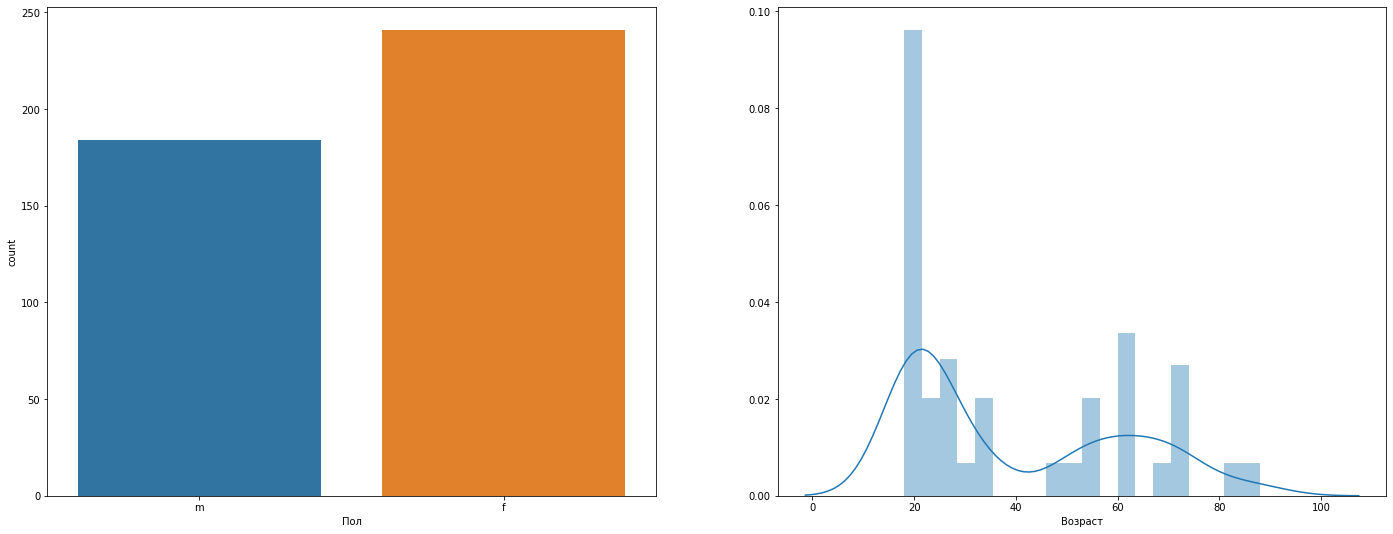

In [24]:
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
sns.countplot(Standart_X['Пол'])
ax2 = fig.add_subplot(122)
sns.distplot(Standart_X['Возраст'], bins=20)

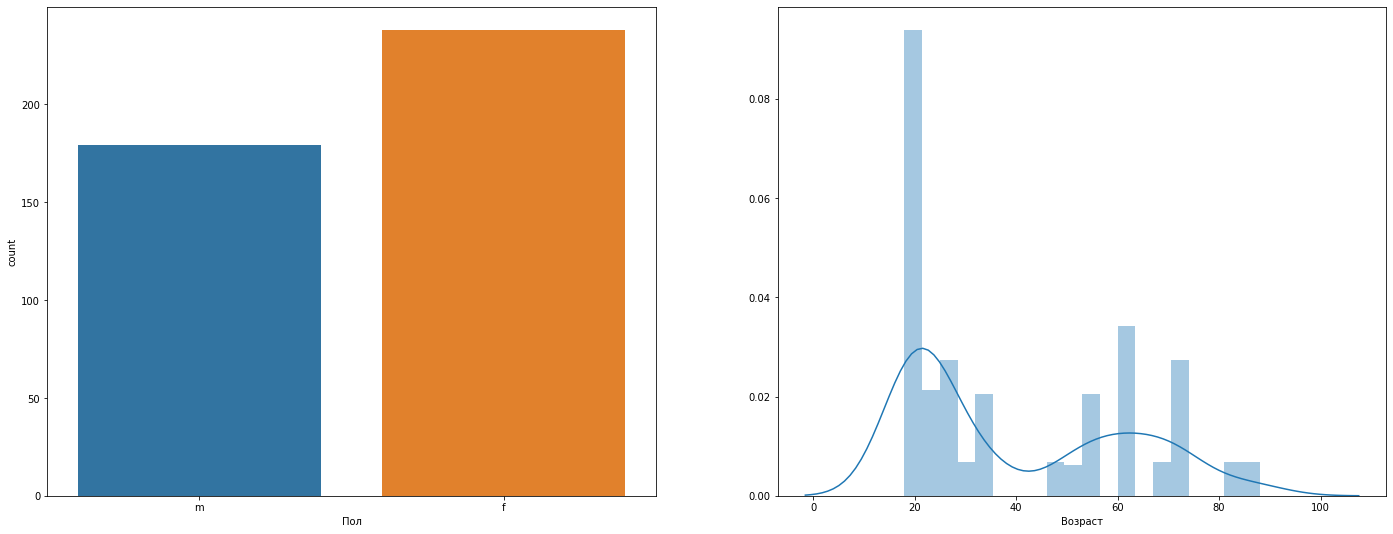

In [25]:
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
sns.countplot(NonStandart_X['Пол'])
ax2 = fig.add_subplot(122)
sns.distplot(NonStandart_X['Возраст'], bins=20)

In [26]:
model = CatBoostClassifier()
model.load_model('catboost_SpectraModel_distrib_by_chms_binary_classification.bin')

In [27]:
Standart_X.columns

Index(['Ch_0_0', 'Ch_0_1', 'Ch_0_2', 'Ch_0_3', 'Ch_0_4', 'Ch_0_5', 'Ch_0_6',
       'Ch_0_7', 'Ch_0_8', 'Ch_0_9', 'Ch_0_10', 'Ch_0_11', 'Ch_0_12',
       'Ch_0_13', 'Ch_0_14', 'Ch_0_15', 'Ch_0_16', 'Ch_0_17', 'Ch_1_0',
       'Ch_1_1', 'Ch_1_2', 'Ch_1_3', 'Ch_1_4', 'Ch_1_5', 'Ch_1_6', 'Ch_1_7',
       'Ch_1_8', 'Ch_1_9', 'Ch_1_10', 'Ch_1_11', 'Ch_1_12', 'Ch_1_13',
       'Ch_1_14', 'Ch_1_15', 'Ch_1_16', 'Ch_1_17', 'Пол', 'Возраст'],
      dtype='object')

In [28]:
model.is_fitted()

True

In [29]:
model.predict(Standart_X)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=6]=189.157 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [ ]:
Standart_y.value_counts()

# PCA

In [35]:
model = CatBoostClassifier()
model.load_model('catboost_PCAModel_distrib_by_chms_binary_classification.bin')

In [36]:
model.is_fitted()

True

In [37]:
N_COMP = 6
pca_model = PCA(n_components=N_COMP)

Standart_PCA_X = pd.DataFrame(pca_model.fit_transform(Standart_X.filter(regex='^Ch')))
Standart_PCA_X['Пол'] = Standart_X['Пол'].values
Standart_PCA_X['Возраст'] = Standart_X['Возраст'].values

NonStandart_PCA_X = pd.DataFrame(pca_model.fit_transform(NonStandart_X.filter(regex='^Ch')))
NonStandart_PCA_X['Пол'] = NonStandart_X['Пол'].values
NonStandart_PCA_X['Возраст'] = NonStandart_X['Возраст'].values

In [38]:
Standart_PCA_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 8 columns):
0          425 non-null float64
1          425 non-null float64
2          425 non-null float64
3          425 non-null float64
4          425 non-null float64
5          425 non-null float64
Пол        425 non-null object
Возраст    425 non-null float64
dtypes: float64(7), object(1)
memory usage: 26.7+ KB


In [39]:
NonStandart_PCA_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 8 columns):
0          417 non-null float64
1          417 non-null float64
2          417 non-null float64
3          417 non-null float64
4          417 non-null float64
5          417 non-null float64
Пол        417 non-null object
Возраст    417 non-null float64
dtypes: float64(7), object(1)
memory usage: 26.2+ KB


In [40]:
## Выведем в csv чтобы посмотреть на проекции
Standart_PCA_X.to_csv('Standart_PCA_X.csv', index=0)
NonStandart_PCA_X.to_csv('NonStandart_PCA_X.csv', index=0)

In [41]:
St_Preds = model.predict(Standart_PCA_X)
NonSt_Preds = model.predict(NonStandart_PCA_X)

In [42]:
print(classification_report(Standart_y, St_Preds))
print(classification_report(NonStandart_y, NonSt_Preds))

              precision    recall  f1-score   support

           0       0.50      0.26      0.34       142
           1       0.70      0.87      0.78       283

    accuracy                           0.67       425
   macro avg       0.60      0.56      0.56       425
weighted avg       0.63      0.67      0.63       425

              precision    recall  f1-score   support

           0       0.25      0.18      0.21       141
           1       0.63      0.72      0.68       276

    accuracy                           0.54       417
   macro avg       0.44      0.45      0.45       417
weighted avg       0.51      0.54      0.52       417



In [43]:
from sklearn.utils import shuffle

In [44]:
ComparingfDF = pd.DataFrame(index=pd.MultiIndex.from_tuples(
              [('Standart','Accuracy'),('Standart','Precision'),('Standart','Recall'),
               ('Non Standart','Accuracy'),('Non Standart','Precision'), ('Non Standart','Recall')],
                 names=['Estimator','Metrics']),
                 columns=['1','2','3','4','5','6','7','8','9','10'])

In [45]:
ComparingfDF

1    2    3    4    5    6    7    8    9   10
Estimator    Metrics                                                    
Standart     Accuracy   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
             Precision  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
             Recall     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Non Standart Accuracy   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
             Precision  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
             Recall     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

for i in range(1,11):
    Stand_X,Stand_y = shuffle(Standart_PCA_X, Standart_y, n_samples=10, random_state=i)
    NonStand_X, NonStand_y = shuffle(NonStandart_PCA_X, NonStandart_y, n_samples=10, random_state=i)
    
    St_Preds = model.predict(Stand_X)
    NonSt_Preds = model.predict(NonStand_X)
    
    ComparingfDF.loc['Standart', str(i)] = np.array([accuracy_score(Stand_y, St_Preds),
                                                     precision_score(Stand_y, St_Preds),
                                                     recall_score(Stand_y, St_Preds)]).round(2)
    ComparingfDF.loc['Non Standart', str(i)] = np.array([accuracy_score(NonStand_y, NonSt_Preds),
                                                     precision_score(NonStand_y, NonSt_Preds),
                                                     recall_score(NonStand_y, NonSt_Preds)]).round(2)

In [47]:
ComparingfDF['mean'] = ComparingfDF.mean(axis=1).values

In [48]:
ComparingfDF

1     2     3     4     5     6     7     8     9  \
Estimator    Metrics                                                           
Standart     Accuracy    0.7   0.8   0.5   0.5   0.8   0.8   0.8   0.5   0.7   
             Precision  0.88  0.88   0.5  0.57  0.86  0.75  0.86  0.57  0.75   
             Recall     0.78  0.88     1  0.67  0.86     1  0.86  0.67  0.86   
Non Standart Accuracy    0.8   0.7   0.5   0.5   0.6   0.5   0.5   0.4   0.4   
             Precision  0.89  0.75  0.83  0.62  0.62  0.56  0.67  0.57  0.57   
             Recall     0.89  0.86  0.56  0.71  0.83  0.83  0.57  0.57  0.57   

                          10   mean  
Estimator    Metrics                 
Standart     Accuracy    0.5  0.660  
             Precision  0.62  0.724  
             Recall     0.71  0.829  
Non Standart Accuracy    0.6  0.550  
             Precision   0.5  0.658  
             Recall     0.75  0.714

In [49]:
print(classification_report( Standart_y ,model.predict(Standart_PCA_X)))

              precision    recall  f1-score   support

           0       0.50      0.26      0.34       142
           1       0.70      0.87      0.78       283

    accuracy                           0.67       425
   macro avg       0.60      0.56      0.56       425
weighted avg       0.63      0.67      0.63       425



In [51]:
print(classification_report( NonStandart_y ,model.predict(NonStandart_PCA_X)))

              precision    recall  f1-score   support

           0       0.25      0.18      0.21       141
           1       0.63      0.72      0.68       276

    accuracy                           0.54       417
   macro avg       0.44      0.45      0.45       417
weighted avg       0.51      0.54      0.52       417

